### Common Test I. Multi-Class Classification (Method 1 - CNN's with Channelwise Attention and Residuals)

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1x5gm4ywOQ8brxMn11KjLBxsehQuxtx19?usp=sharing)*

**Strategy**: Before starting any Deep Learning task, we must set a baseline and try simple models to understand and monitor the factors affecting model convergence. Hence in this task we define a CNN with two branches that contain a channelwise attention mechanism to refine the features learned by the network. The architecture is designed to capture different types of features from the input image and then combine them for the final classification. 

Here are the steps in detail: 
*   Firstly, we define a convolutional base to extract hierarchical features from the input image.
*   Then the output is fed into two branches, which helps in channel-wise feature recalibration
*   An attention mechanism is implemented by applying Global Average Pooling, followed by two dense layers with a sigmoid activation function at the end. This generates an attention map that is element-wise multiplied with both branches to emphasize relevant features. In simpler terms, the code uses the Global Average Pooling layer to generate a global representation of the shared feature maps. Then, the representation is passed through two dense layers to learn a set of weights that indicate the importance of each channel. These weights are then used to modulate the feature maps through an element-wise multiplication operation, which enables the network to focus on the most informative parts of the input image.
*   The network then learns to refine the features in the two branches by applying a residual learning strategy which involves subtracting, convolving, batch normalizing, and adding the features back to the original branches.
*   Finally, the features from both branches are concatenated



**Results:** Average AUC on validation set is 0.8 (This model was just for setting a baseline, so the other notebooks in this folder that implement other methods show better results, please see them)

<img src="results/results_Channelwise_Attention_CNN.png" alt="(Image Load Error: Unable to load image, make sure you have downloaded the results folder)" width="700"/>


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from keras import layers
from keras import models
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image

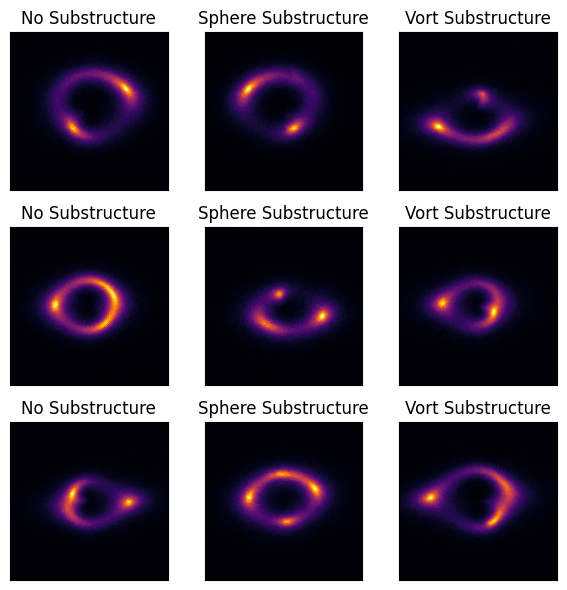

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

for i, (folder_path, title) in enumerate([('converted_train/no/', 'No Substructure'), ('converted_train/sphere/', 'Sphere Substructure'), ('converted_train/vort/', 'Vort Substructure')]):
    for j in range(3):
        file_name = os.listdir(folder_path)[j]
        img_path = os.path.join(folder_path, file_name)
        img = Image.open(img_path)
        img_array = np.array(img)
        axs[j, i].imshow(img_array, cmap='inferno')
        axs[j, i].set_title(title)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
plt.tight_layout()
plt.show()

In [3]:
# Here we will define datagenerators to reduce memory consumption so we can accept data in batches instead of loading the entire dataset at once
def custom_data_generator(directory, classes, target_size, batch_size, shuffle=True):
    """
    About: 
        Custom data generator to generate batches of images and their labels from a directory of images to reduce memory consumption

    Args:
        :param directory (str): The directory where the images are located
        :param classes (list): A list of the classes in the dataset
        :param target_size (tuple): A tuple of integers representing the target size of the images after resizing
        :param batch_size (int): The number of images to include in each batch
        :param shuffle (bool, optional): Whether to shuffle the order of the images. Defaults to True

    Return:
        Image and corresponding labels in batches.
    """
    filepaths = []
    labels = []

    for label in classes:
        class_dir = os.path.join(directory, label)
        for filename in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, filename))
            labels.append(label)

    indexes = np.arange(len(filepaths))
    if shuffle:
        np.random.shuffle(indexes)

    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)

    while True:
        for start_idx in range(0, len(indexes), batch_size):
            end_idx = min(start_idx + batch_size, len(indexes))
            batch_indexes = indexes[start_idx:end_idx]

            X = np.empty((len(batch_indexes), *target_size, 3))
            y = np.empty((len(batch_indexes)), dtype=int)

            for i, idx in enumerate(batch_indexes):
                img = np.load(filepaths[idx])
                img = img.reshape((150, 150, 1))
                img = tf.reshape(tf.broadcast_to(img, (150, 150, 3)), (150, 150, 3))
                img = tf.image.resize(np.array(img), target_size)
                X[i] = img
                y[i] = labels[idx]

            y = tf.keras.utils.to_categorical(y, num_classes=len(classes))
            yield X, y

train_dir = 'dataset/train/'
val_dir = 'dataset/val/'


batch_size = 64
target_size = (224, 224)
classes = ['no', 'sphere', 'vort']

train_generator = custom_data_generator(train_dir, classes, target_size, batch_size, shuffle=True)
validation_generator = custom_data_generator(val_dir, classes, target_size, batch_size, shuffle=False)

def count_files_in_dirs(directory, classes):
    count = 0
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        count += len(os.listdir(class_dir))
    return count

train_files_count = count_files_in_dirs(train_dir, classes)
val_files_count = count_files_in_dirs(val_dir, classes)


In [2]:
def Channelwise_Attention_CNN(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    shared = layers.Conv2D(128, (3, 3), activation="relu")(x)
    shared = layers.MaxPooling2D((2, 2))(shared)

    branch1 = layers.Conv2D(128, (1, 1), activation="relu")(shared)
    branch2 = layers.Conv2D(128, (1, 1), activation="relu")(shared)

    # Channel-wise attention
    attention = layers.GlobalAveragePooling2D()(shared)
    attention = layers.Dense(64, activation="relu")(attention)
    attention = layers.Dense(128, activation="sigmoid")(attention)
    attention = layers.Reshape((1, 1, 128))(attention)
    branch1 = layers.Multiply()([branch1, attention])
    branch2 = layers.Multiply()([branch2, attention])

    x = layers.Subtract()([branch1, branch2])
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([branch1, x])
    branch1 = layers.Activation("relu")(x)

    x = layers.Subtract()([branch2, branch1])
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([branch2, x])
    branch2 = layers.Activation("relu")(x)

    x = layers.Concatenate()([branch1, branch2])

    x = layers.Flatten()(x)
    
    outputs = layers.Dense(3, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
opt = optimizers.Adam(learning_rate=1e-5)
model = Channelwise_Attention_CNN((224, 224, 3))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

model.fit(train_generator,
          steps_per_epoch=train_files_count // batch_size,         
          validation_data=validation_generator,
          validation_steps=val_files_count // batch_size,
          epochs=200,
          callbacks=[checkpoint])

Epoch 1/200
468/468 [==============================] - ETA: 0s - loss: 1.1238 - auc: 0.5049
Epoch 1: val_auc improved from -inf to 0.50414, saving model to model_checkpoint.h5
468/468 [==============================] - 454s 941ms/step - loss: 1.1238 - auc: 0.5049 - val_loss: 1.0987 - val_auc: 0.5041
Epoch 2/200
468/468 [==============================] - ETA: 0s - loss: 1.1020 - auc: 0.5327
Epoch 2: val_auc improved from 0.50414 to 0.52295, saving model to model_checkpoint.h5
468/468 [==============================] - 257s 546ms/step - loss: 1.1020 - auc: 0.5327 - val_loss: 1.1038 - val_auc: 0.5229
Epoch 3/200
468/468 [==============================] - ETA: 0s - loss: 1.0938 - auc: 0.5514
Epoch 3: val_auc improved from 0.52295 to 0.52778, saving model to model_checkpoint.h5
468/468 [==============================] - 289s 618ms/step - loss: 1.0938 - auc: 0.5514 - val_loss: 1.1038 - val_auc: 0.5278
Epoch 4/200
468/468 [==============================] - ETA: 0s - loss: 1.0875 - auc: 0.5657

In [ ]:
# model.save('Channelwise_Attention_CNN.h5')

In [3]:
import keras
selfsupervised_equivariant_model = keras.models.load_model('models/Channelwise_Attention_CNN.h5')

In [ ]:
y_true = []
y_pred = []

for X_batch, y_batch in validation_generator:
    y_true.extend(y_batch)
    y_pred.extend(selfsupervised_equivariant_model.predict(X_batch))

    if len(y_true) >= val_files_count:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

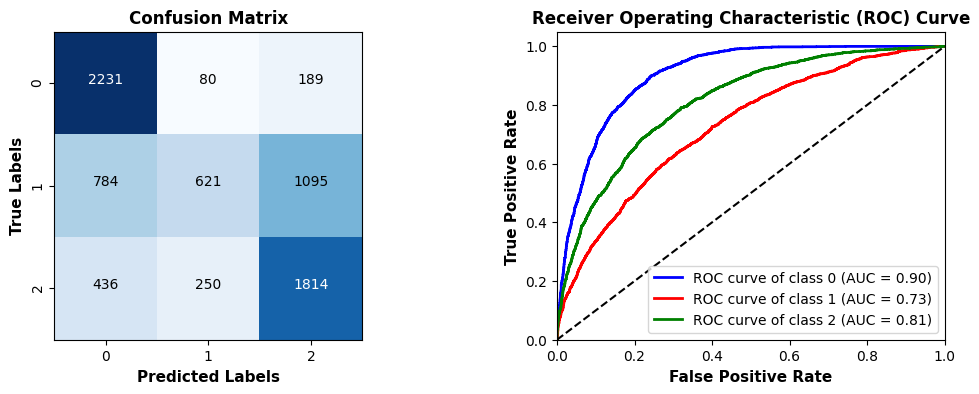

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 4)) 
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.subplot(121)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=11, fontweight='bold')
plt.ylabel('True Labels', fontsize=11, fontweight='bold')

tick_marks = np.arange(3)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks, rotation=90)
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(122)
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.4)
plt.show()
